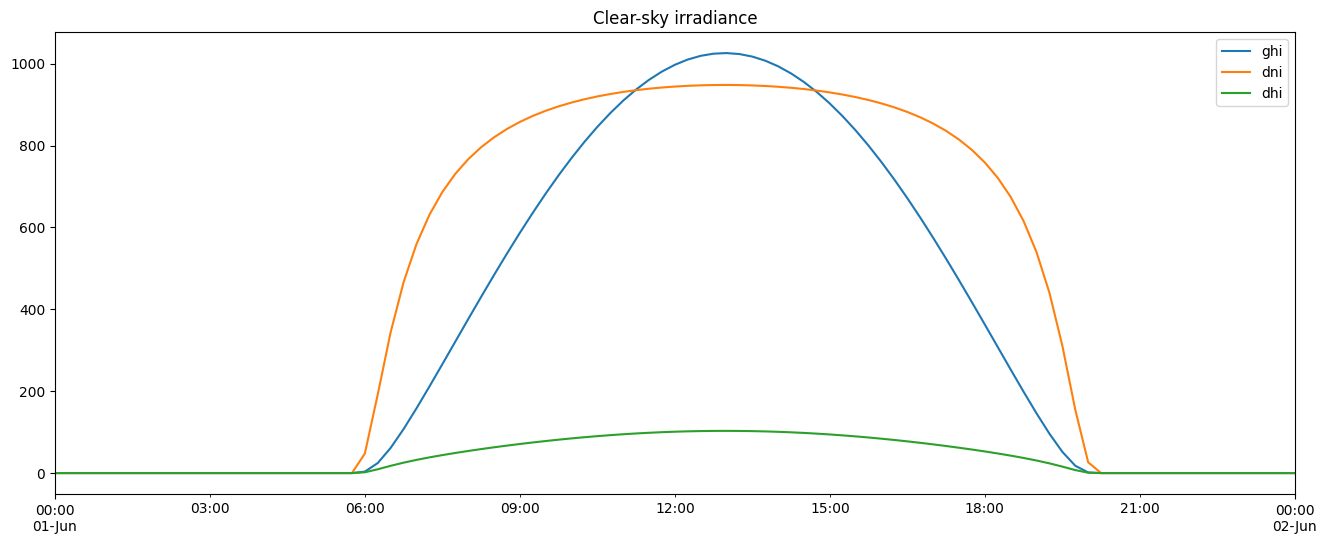

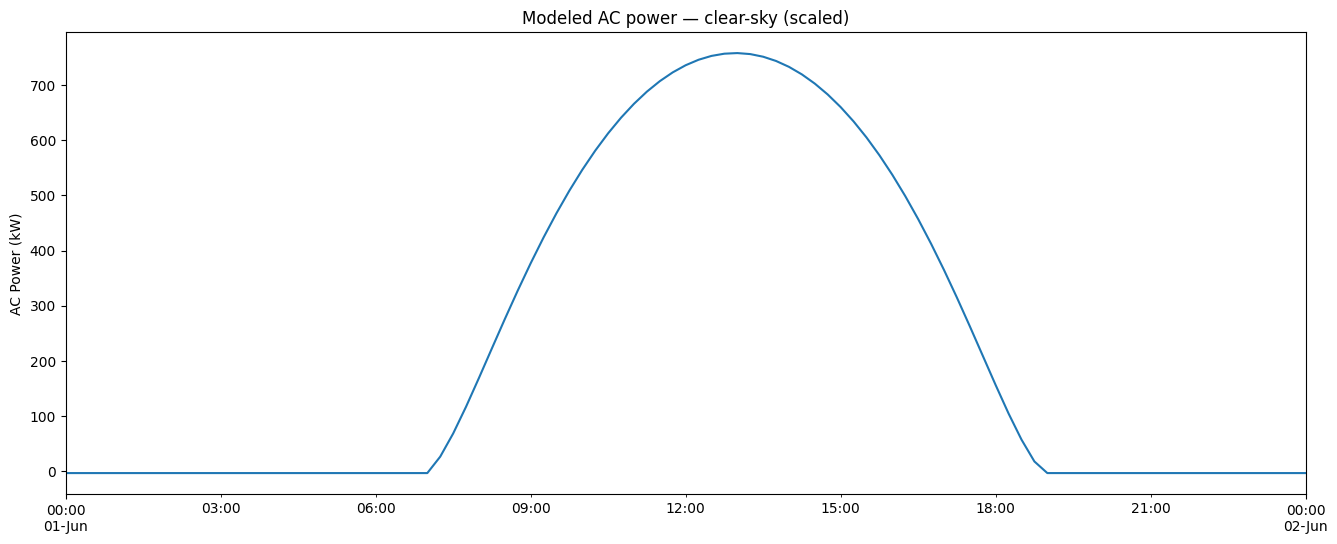

In [9]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt

from pvlib.location import Location
from pvlib.pvsystem import PVSystem
from pvlib.modelchain import ModelChain


location = Location(
    latitude=35.37495,
    longitude=-120.05370,
    tz="US/Pacific",
    altitude=620,
    name="Topaz Solar Farm",
)

MODULE_KEY = "First_Solar__Inc__FS_390"
INVERTER_KEY = "SMA_America__SC630CP_US__with_ABB_EcoDry_Ultra_transformer_"

TILT = 25
AZIMUTH = 180
DC_AC_TARGET = 1.25
VOC_MARGIN = 0.95
BLOCK_STRINGS = 50


modules = pvlib.pvsystem.retrieve_sam("CECMod")
inverters = pvlib.pvsystem.retrieve_sam("CECInverter").T

module = modules[MODULE_KEY]
inverter = inverters.loc[INVERTER_KEY]


voc = module["V_oc_ref"]
vmp = module["V_mp_ref"]
pmp_kw = module["STC"] / 1000

vdcmax = inverter["Vdcmax"]
paco_kw = inverter["Paco"] / 1000

modules_per_string = int((VOC_MARGIN * vdcmax) // voc)
modules_per_string = max(modules_per_string, 1)

kw_per_string = modules_per_string * pmp_kw
strings_equiv = int(round((paco_kw * DC_AC_TARGET) / kw_per_string))
strings_equiv = max(strings_equiv, 1)

scale_factor = strings_equiv / BLOCK_STRINGS


temp_params = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS["sapm"]["open_rack_glass_glass"]

system = PVSystem(
    surface_tilt=TILT,
    surface_azimuth=AZIMUTH,
    module_parameters=module,
    inverter_parameters=inverter,
    modules_per_string=modules_per_string,
    strings_per_inverter=BLOCK_STRINGS,
    temperature_model_parameters=temp_params,
)

modelchain = ModelChain(system, location, aoi_model="physical", spectral_model="no_loss")


times = pd.date_range(
    "2022-06-01 00:00",
    "2022-06-02 00:00",
    freq="15min",
    tz=location.tz,
)

clear_sky = location.get_clearsky(times)
clear_sky.plot(figsize=(16, 6), title="Clear-sky irradiance")
plt.show()

modelchain.run_model(clear_sky)
(ac_equivalent := modelchain.results.ac * scale_factor / 1000).plot(
    figsize=(16, 6),
    title="Modeled AC power — clear-sky (scaled)",
    ylabel="AC Power (kW)",
)
plt.show()


The clear-sky irradiance and modeled AC power plots serve as a sanity check for the system configuration and modeling assumptions. Under idealized clear-sky conditions, the irradiance profiles (GHI, DNI, and DHI) follow the expected smooth diurnal pattern driven by solar position, with peak values occurring near solar noon and near-zero values at night. The resulting modeled AC power curve mirrors this behavior, producing a smooth, bell-shaped output profile that ramps up after sunrise, peaks around midday, and declines toward sunset. The absence of discontinuities, clipping artifacts, or nonphysical behavior indicates that the site definition, component selection, string sizing, and DC/AC scaling are internally consistent. This clear-sky run provides confidence that the pvlib model is behaving as expected before introducing real or typical meteorological weather data for expected energy analysis.

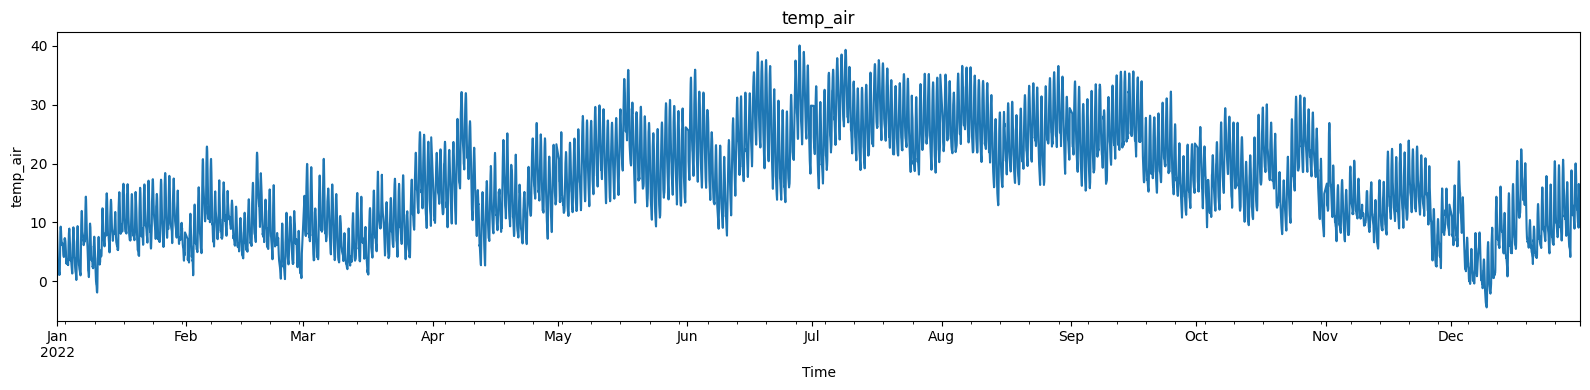

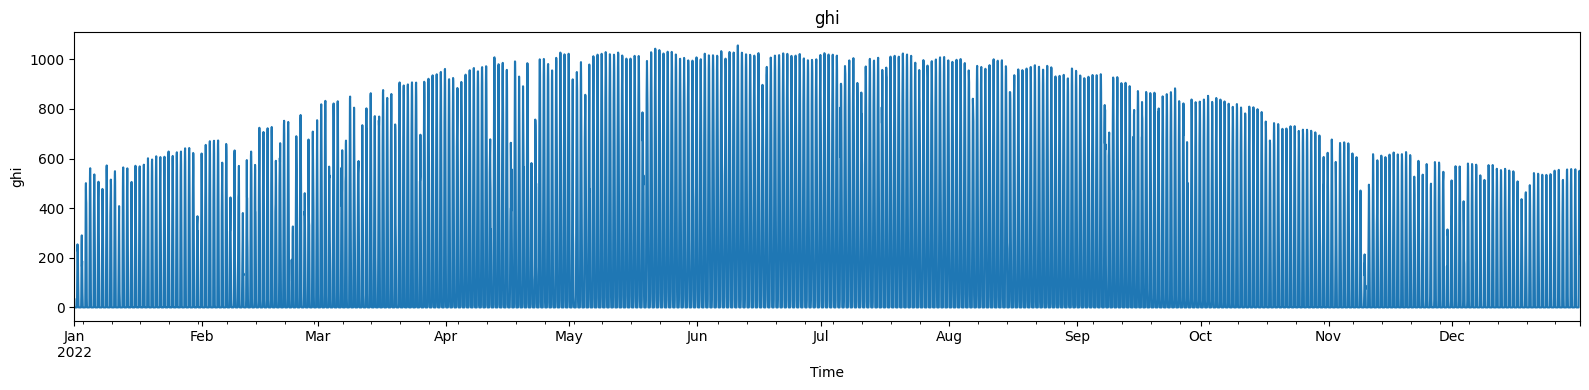

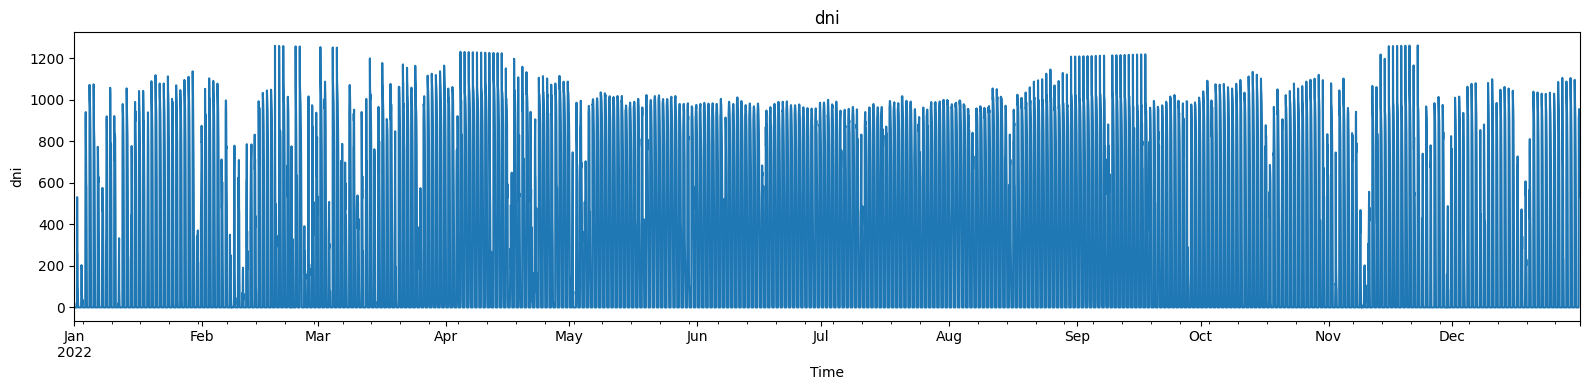

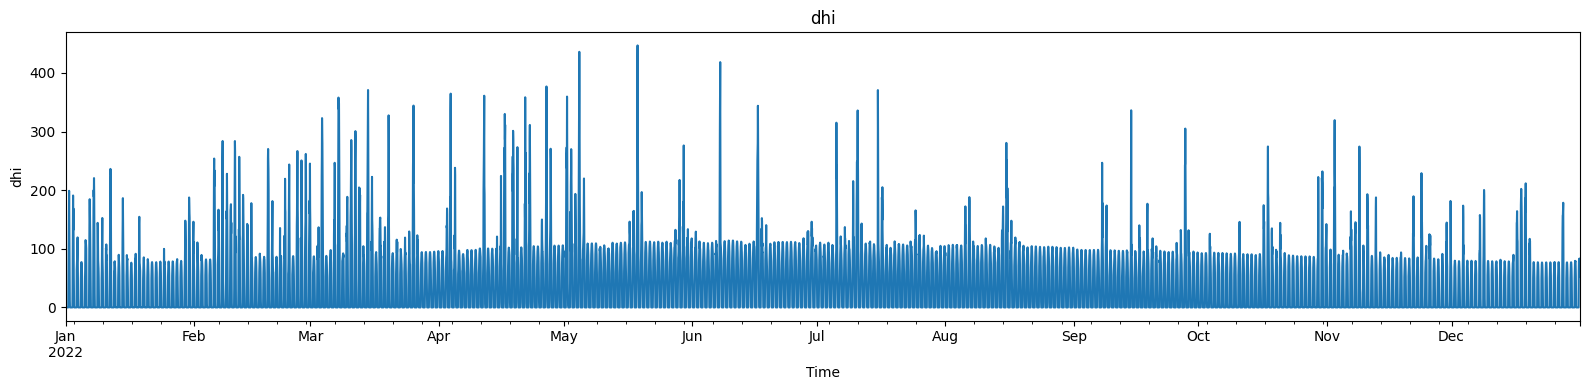

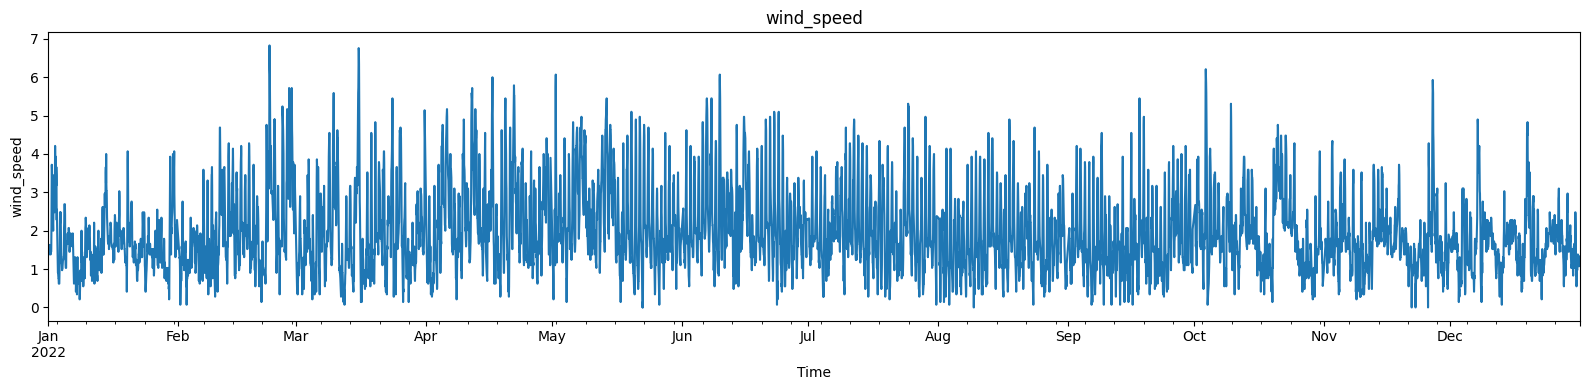

In [12]:
tmy = pd.read_csv("tmy_topaz_2005_2023.csv", skiprows=17, nrows=8760,
                  usecols=['time(UTC)', 'T2m', 'G(h)', 'Gb(n)', 'Gd(h)', 'WS10m'], index_col=0)

#tmy.index = pd.to_datetime(tmy.index, format= "%Y%m%d : %H%M")
tmy.index = pd.date_range(start="2022-01-01 00:00", end="2022-12-31 23:00", freq="H")

tmy.columns = ['temp_air', 'ghi', 'dni', 'dhi', 'wind_speed']

for col in tmy.columns:
    ax = tmy[col].plot(figsize=(16, 4))
    ax.set_title(col)
    ax.set_xlabel("Time")
    ax.set_ylabel(col)
    plt.tight_layout()
    plt.show()


tmy.to_csv("tmy_topaz_2022.csv")

The Typical Meteorological Year (TMY) dataset used in this analysis was obtained from PVGIS (Photovoltaic Geographical Information System), which provides long-term, satellite-derived and reanalysis-based solar and meteorological data. PVGIS constructs TMY files by selecting representative months from a multi-year historical record, producing a synthetic year that reflects typical site conditions rather than any single calendar year. This makes the dataset well-suited for expected production modeling and long-term performance benchmarking. I extracted the 2022 calender year data because it was the most recent and relevant data avaliable.

In the figure above, global horizontal irradiance (GHI) exhibits the expected smooth, seasonal bell-shaped envelope, with higher average values during summer months driven primarily by longer daylight hours and higher solar elevation. In contrast, direct normal irradiance (DNI) shows greater variability throughout the year and does not strictly peak in summer. While summer months have relatively stable but slightly lower average DNI, winter months display higher peak DNI values alongside deeper troughs, resulting in greater volatility. This behavior reflects atmospheric effects such as cloud cover, aerosol loading, and sun angle, which disproportionately affect direct beam radiation compared to diffuse components. As a result, DNI can be higher on clear winter days but more inconsistent overall, whereas GHI remains more seasonally stable due to its inclusion of both direct and diffuse irradiance components. The diffuse horizontal irraidance (DHI) on the other hand has a pretty consistent small hump shape with occasional peaks that are fairly evenly distributed thoughout. 

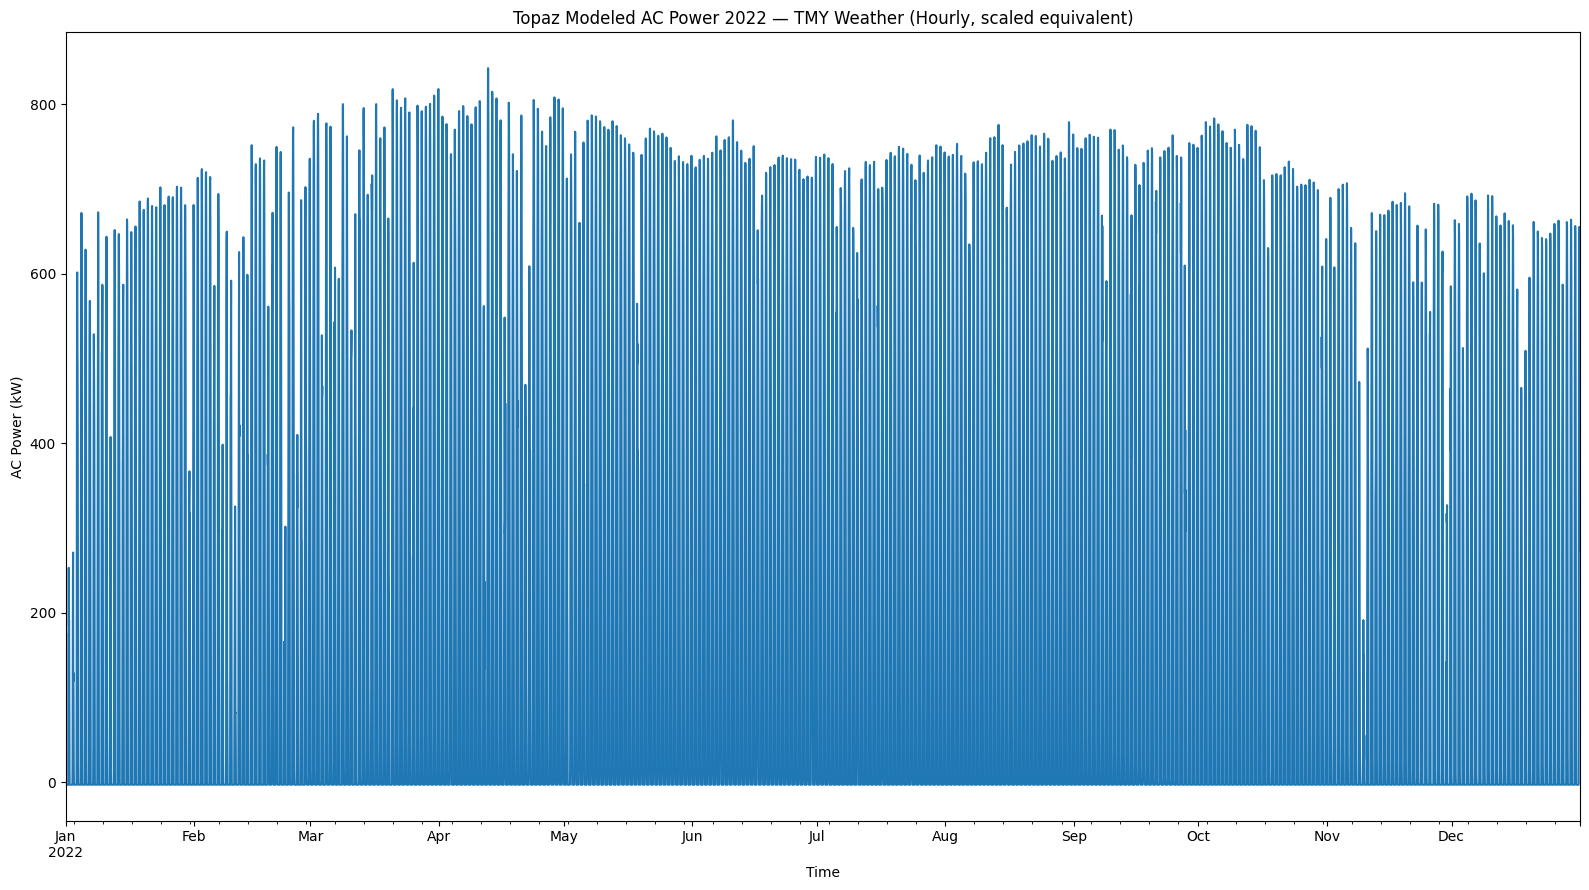

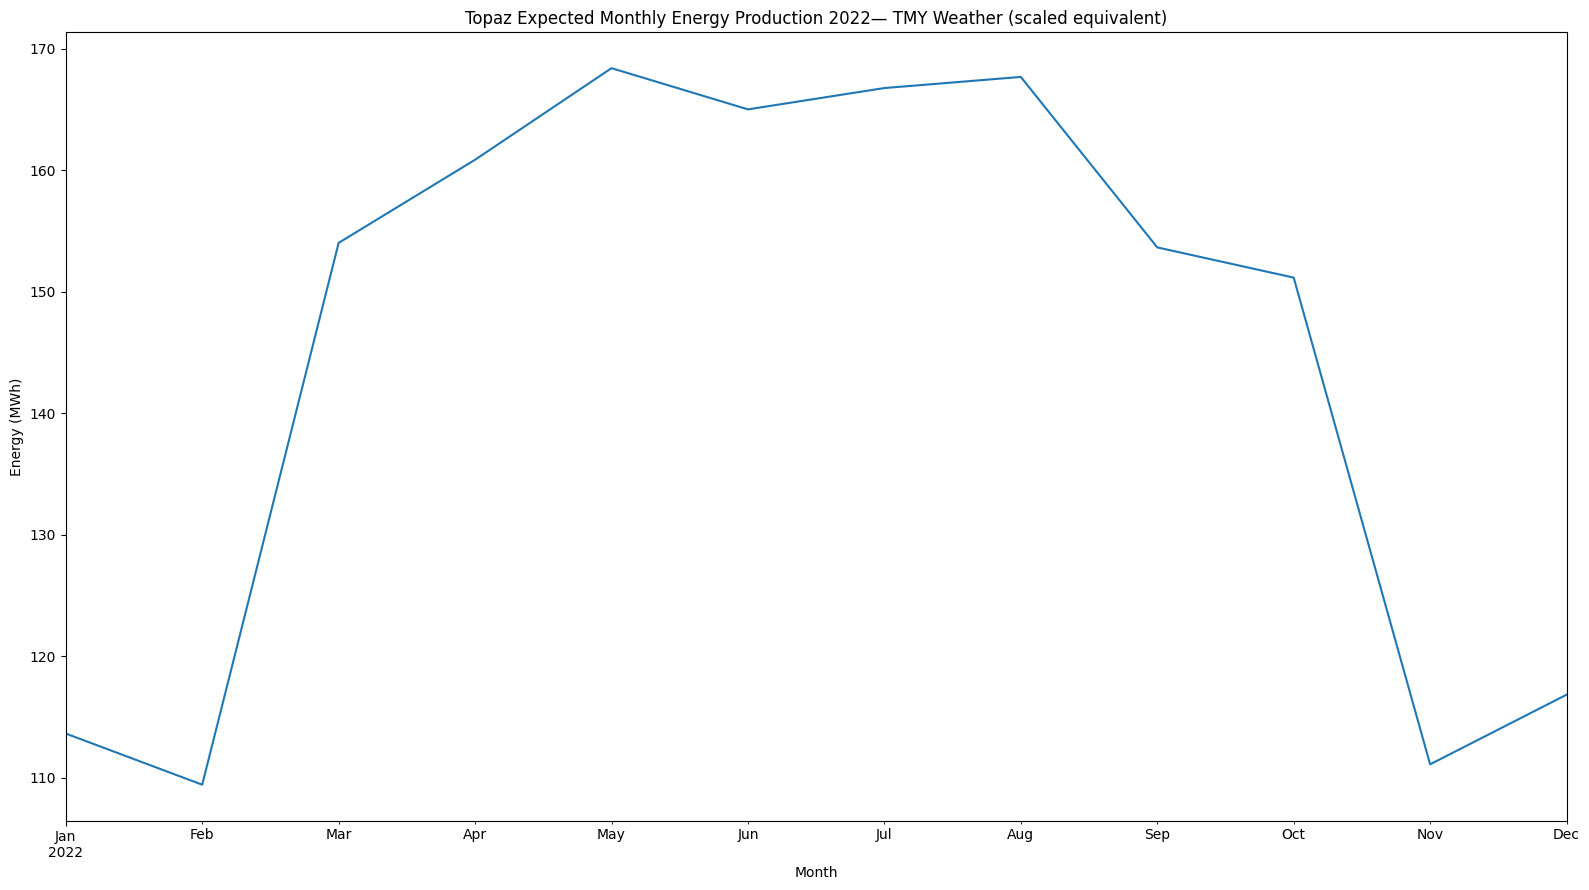

In [11]:
tmy = pd.read_csv("tmy_topaz_2022.csv", index_col=0)

tmy.index = pd.to_datetime(tmy.index)
modelchain.run_model(tmy)
ac_equiv = modelchain.results.ac * scale_factor

ax = (ac_equiv/1000).plot(figsize=(16,9))
ax.set_title("Topaz Modeled AC Power 2022 — TMY Weather (Hourly, scaled equivalent)")
ax.set_xlabel("Time")
ax.set_ylabel("AC Power (kW)")
plt.tight_layout()
plt.show()

monthly_mwh = ac_equiv.resample("M").sum() / 1e6
ax = monthly_mwh.plot(figsize=(16,9))
ax.set_title("Topaz Expected Monthly Energy Production 2022— TMY Weather (scaled equivalent)")
ax.set_xlabel("Month")
ax.set_ylabel("Energy (MWh)")
plt.tight_layout()
plt.show()




The hourly AC power time series shows the characteristic daily solar production pattern across the year, with higher midday peaks during spring and summer driven by longer daylight hours and higher solar elevation, and lower peaks during winter months reflecting reduced solar resource. Day-to-day variability within each season captures typical atmospheric conditions embedded in the TMY data, rather than site-specific operational effects.

Aggregating the hourly AC power to monthly energy highlights the seasonal distribution of expected production. Energy output increases from winter into spring, peaks through late spring and summer, and declines into fall and winter as day length and sun angle decrease. The relatively flat summer peak reflects the balance between increased irradiance and higher module temperatures, which partially offset gains in solar resource. Together, these plots define a stable, weather-normalized expected production baseline suitable for benchmarking actual SCADA energy and assessing long-term plant performance.